# Solving ODEs Numerically Using an Explicit RK Scheme
We are going to learn how to solve and plot an ODE
$$y' = f(y)$$
in Julia.

The first thing we are going to do is learn why we can focus on 1st order autonomous ODEs.

### Eliminating an explicit time variable t

If I have a non-autonomous ode 
$$z' = g(t,z)$$
then I can simply define 
$y = [t, z]$ and $f(y)=[1,g(y)]$
to convert to an autonomous system with one more variable. 

### Eliminating Second Derivatives

If I have a second order ODE 
$$z'' = g(z,z')$$
in an $n$ dimensional vector variable $z$ then I can simply define 
$y = [z, z']$ and $f(y)=[y[n+1:2n],g(y)]$
and convert to a first order system with vectors of length $2 n$. 

### Explicit Euler Scheme
The explicit Euler scheme just approximates the ODE 
$$y'=f(y)$$
over a step of length $h_n$ starting at $y_n$
with the slope (given by $f(y_n)$) 
at the start of the step.  This gives
$$
y_{n+1} = y_n + h_n f(y_n) 
$$
with $y_0$ defined by the initial condition. This is essentially
the *right hand rule* for approximating integrals from Calculus. The fanciest
integratiuon rule you learned in Calculus was probably *Simpson's Rule*

Euler's method is easy to implement.  Obvious questions are:
   - How big should $h_n$ be?
   - Is it worth doing something fancier?
 I guess we should implement Euler's method first.
 
 We have some questions to think about first:
  - How do we want to store the ys?
  - Do we want to explicitly store t?
  - Do we want to save the values of h?
  
 Answers: 
  - How do we want to store the ys?  2D Array size times MaxSteps
  - Do we want to explicitly store t?   Store t.
  - Do we want to save the values of h? Compute $h_n = t_{n+1}-t_{n}$

In [4]:
function EulerStep(f,y,h)
    k1=f(y)
    y + h*k1
end

EulerStep (generic function with 1 method)

### Explicit MidPoint Scheme
The explicit MidPoint scheme for the ODE 
$$y'=f(y)$$
over a step of length $h_n$ starting at $y_n$
first approximates the mid point $y(t_n + 0.5 h_n)$ using an explicit Euler Step
$$
y_{mid} = y_n + h_n 0.5 f(y_n)
$$
and then
approximates $y(t_n + h_n)$ using the slope at this approximate midpoint
$$
y_{n+1} = y_n + h_n f(y_{mid}). 
$$
This is an implementation of something like the *mid-point* rule in Calculus. 

In [5]:
function MidStep(f,y,h)
    k1 = f(y)
    z2 = y + 0.5*h*k1
    k2 = f(z2)
    y + h*k2
end

MidStep (generic function with 1 method)

### Explicit Trapezoid Scheme
The explicit Trapezoid scheme for the ODE 
$$y'=f(y)$$
over a step of length $h_n$ starting at $y_n$
approximates the end point $y(t_n + h_n)$ using an explicit Euler step
$$
y_{end} = y_n + h_n f(y_n)
$$
then
approximates $y(t_n + h_n)$ using the average of the slopes at the start and the slope at the end
$$
y_{n+1} = y_n + h_n (0.5 f(y_{n})+ 0.5 f(y_{end})) 
$$
This is an implementation of something like the *trapezoid* rule in Calculus. 

In [6]:
function TrapStep(f,y,h)
    k1 = f(y)
    z2 = y + 1.0*h*k1
    k2 = f(z2)
    y + h*(0.5*k1 + 0.5*k2)
end

TrapStep (generic function with 1 method)

### General Explicit RK scheme
A general RK scheme is defined by a strictly lower triangular matrix 
$A$ which specifies the sequential evaluations of the internal slopes
from the function $f$ and a vector $b$ which specifies how to 
average the slopes together to compute $y_{n+1}$. The size of the vector 
$b$ (or equivalently the square matrix $A$) is the number of internal stages and 
measures how complicated the scheme is.  

The standard 
terminology uses $z_i$ for the sequentially computed internal stages 
and $k_i = f(z_i)$ for the internal stage slopes through
$$
z_i = y_n + h_n \left( \sum_{j=1}^{s} a_{i,j} k_j \right)  
\quad
\mbox{with}
\quad
k_i = f(z_i)
$$
and the external step is computed from the stage slopes through
$$
y_{n+1} = y_n + h_n \sum_{j=1}^s b_j k_j
$$

In the real world solvers include two different $b$ vectors.  One is used to advance the scheme and the other is used to adjust the step size $h_n$ to control the error. 

We are going to write a stepper for either the mid point or trapezoid rule and one of the rk schemes from the wiki page. 

Then we are going to write a general solver which performs a general RK step from a Butcher Tableau.  We are going to store the data as a structure.

# Code

### Data acquisition and Data Structure

Mathpix can digitize the arrays on wikipedia accurately.   The process is screen grab the array you want and import it into MathPix. Copying and pasting one of the simple 
formats into a Jupyter notebook givse some thing that requires minimal editing.
I filled in the missing zeros and deleted commas and spare brackets. 

Here is a definition of a suitable structure.  A toy example for the Trap rule with a placeholder for bHat is included.  I am going to build a real example from the Wiki page. You access the pieces of the structure using the "." syntax.


In [2]:
struct RKTable
    A::Matrix{Float64}
    b::Vector{Float64}
    bHat::Vector{Float64}
end

TrapTable = RKTable([
    [0 0]
    [1 0]],
    [1/2,1/2],[0,0])

RKTable([0.0 0.0; 1.0 0.0], [0.5, 0.5], [0.0, 0.0])

## MathPix import
There is an AI tool called MathPix that can parse the data for RK methods from the wiki page.

Here is one way to use it. 

In [3]:
A=[
    [0 0 0 0 0 0]
    [1//4 0 0 0 0 0]
    [3//32 9//32 0 0 0 0 ]
    [1932//2197 -7200//2197 7296//2197 0 0 0]
    [439//216 -8 3680//513 -845//4104 0 0]
    [-8//27 2 -3544//2565 1859//4104 -11//40 0]
    ]
b = [16//135, 0, 6656//12825, 28561//56430, -9//50, 2//55]
bHat = [25//216, 0, 1408//2565, 2197//4104, -1//5, 0] 
RKF45 = RKTable(A, b, bHat)

RKTable([0.0 0.0 … 0.0 0.0; 0.25 0.0 … 0.0 0.0; … ; 2.0324074074074074 -8.0 … 0.0 0.0; -0.2962962962962963 2.0 … -0.275 0.0], [0.11851851851851852, 0.0, 0.5189863547758284, 0.5061314903420167, -0.18, 0.03636363636363636], [0.11574074074074074, 0.0, 0.5489278752436647, 0.5353313840155945, -0.2, 0.0])

## General Stepper
The general explicit RK stepper is going to take a "yOld", an "f" and an "h" and advance yOld to two different approximations y and yHat using a specified RK scheme 

In [4]:
function RKStep(yOld,h,f,scheme::RKTable)
    # extract RK scheme
    A=scheme.A; b=scheme.b; bHat=scheme.bHat
    # Extract dimension of ODE and stages of scheme
    n=size(yOld)[1];s=size(A)[1]
    # Assign space for the function evaluations
    K = zeros(n,s)
    # Compute slopes 
    for i in 1:s
        # Assign Appropriate Slopes
        z = yOld
        for j in 1:i-1
            z+=h*(A[i,j]*K[:,j])
        end
        K[:,s] = f(z)
    end
    
    # Compute the outputs
    y=yOld
    yHat=yOld
    for i in 1:s
        y+=h*b[i]*K[:,i]
        yHat+=h*bHat[i]*K[:,i]
    end
    # Return the output as
    [y yHat]
end

RKStep (generic function with 1 method)

## Test Problem

### Lotka Volterra Eqns
We decided to use the Lotka-Volterra predator prey system
https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations
$$
\begin{align}
x'(t) &= \alpha x - \beta x y \\
y'(t) &= \delta x y - \gamma y
\end{align}
$$
with the parameters 
$\alpha=1.1$, 
$\beta=0.4$
$\delta=0.1$
and $\gamma = 0.4$.
To reproduce the figures from the wiki 
page we should run our simulations for something like $100$ time units.  

The appropriate function is easy enough to define.  It is important to make sure that it is returning the correct type.  It is important to make sure it is taking the arguments that the ODE suit is expecting. 

In [21]:
function LV(z,p,t)
    alpha = 1.1
    beta  = 0.4
    delta = 0.1
    gamma = 0.4
    [alpha*z[1]-beta*z[1]z[2], delta*z[1]*z[2]- gamma*z[2]] 
end
z=[1.2,3.4]
p=[]
t0=0.0
LV(z,p,t0)

2-element Vector{Float64}:
 -0.31200000000000006
 -0.9520000000000002

In [24]:
using DifferentialEquations
IVP = ODEProblem(LV, [10.0,10.0], (0.0,100.0))

ODEProblem with uType Vector{Float64} and tType Float64. In-place: false
timespan: (0.0, 100.0)
u0: 2-element Vector{Float64}:
 10.0
 10.0

In [25]:
IVPSol = solve(IVP,Tsit5())

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\struther\.julia\packages\SciMLBase\QqtZA\src\retcodes.jl:355


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 142-element Vector{Float64}:
   0.0
   0.07357835940595923
   0.21479426650201644
   0.35563949013670204
   0.5212238498504295
   0.7011992943596838
   0.9050940164233857
   1.1326320487092492
   1.3926285331841866
   1.6943736149615627
   2.063446055604929
   2.681310146601933
   3.1003695363449286
   ⋮
  89.03186099285517
  89.6697222853456
  90.36650374846452
  91.27534819617131
  92.53849390858926
  93.88008889611253
  95.098272537009
  96.31562725251821
  97.51831469558364
  98.61433292899412
  99.5583208980259
 100.0
u: 142-element Vector{Vector{Float64}}:
 [10.0, 10.0]
 [8.031555572440048, 10.37383344731287]
 [5.156462791296532, 10.746549622036499]
 [3.279771508328707, 10.768980683519379]
 [1.9422428401725107, 10.51337825344607]
 [1.1284693376663517, 10.049843644126613]
 [0.6379816890008774, 9.425899362059566]
 [0.3591342471099189, 8.700910119542735]
 [0.20174314945666882, 7.896943269585648]
 [0.114298

Looks as though it does the separate plots by default.  Since this makes sense in any number of dimensions it seems like a reasonable default. In the eyeball norm this matches the wikipedia output. Note, the ODE approximation took 142 steps with Tsit5(). 

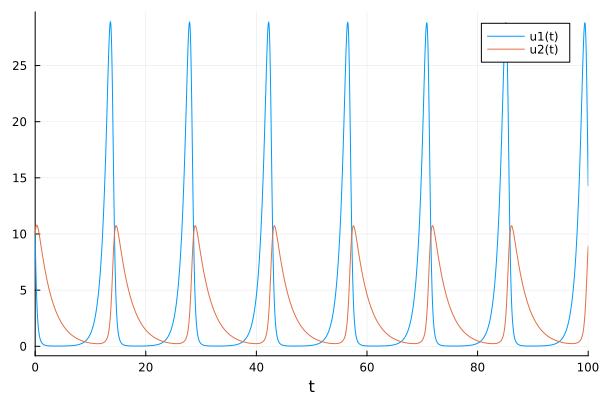

In [29]:
using(Plots)
plot(IVPSol)

You can plot other things easily.  Here is the phase plane plot. You can see the corners! 

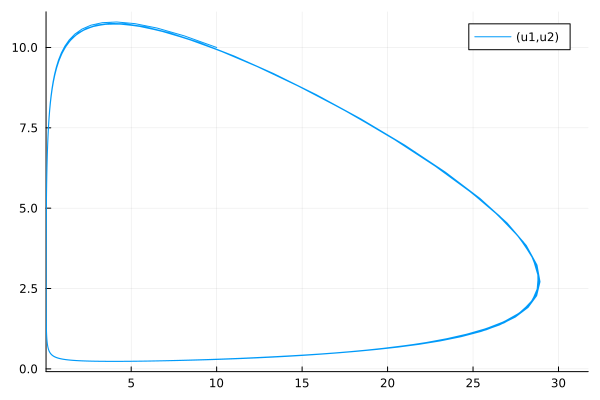

In [32]:
plot(IVPSol, idxs = (1, 2))

In [33]:
IVPSol = solve(IVP,BS3())

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\struther\.julia\packages\SciMLBase\QqtZA\src\retcodes.jl:355


retcode: Success
Interpolation: 3rd order Hermite
t: 464-element Vector{Float64}:
   0.0
   0.012919632691424182
   0.03822239026563175
   0.07573636342295131
   0.13088281610247157
   0.1872476729127548
   0.25239214785519415
   0.3212727129689201
   0.3949198897978014
   0.47168856726877745
   0.5515221556492564
   0.6339129023182096
   0.7187997800489053
   ⋮
  97.57248659641462
  97.86373310512941
  98.15303989820744
  98.43756180344486
  98.71052383858454
  98.96331231613111
  99.19213616926258
  99.39727404300795
  99.58094182557497
  99.74616810133791
  99.896282856584
 100.0
u: 464-element Vector{Vector{Float64}}:
 [10.0, 10.0]
 [9.63036858002318, 10.075402085218542]
 [8.935936505696638, 10.210909253271602]
 [7.978830542814343, 10.382811678079545]
 [6.727185686545819, 10.575741253367479]
 [5.630026398219867, 10.705574540401342]
 [4.570452490204328, 10.781457194851138]
 [3.6619403426304222, 10.788980309424192]
 [2.8914859394200914, 10.730581131052293]
 [2.266498472982938, 10.613

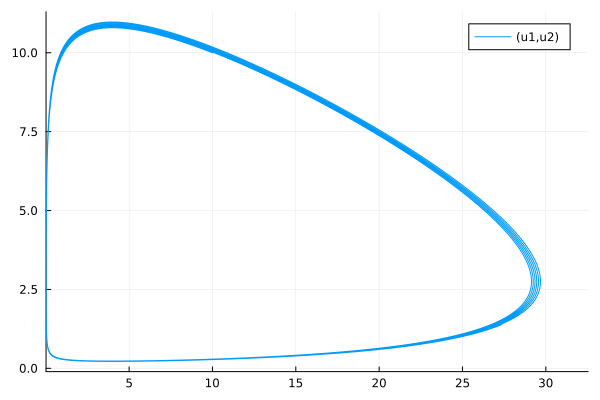

In [34]:
plot(IVPSol, idxs = (1, 2))